In [35]:
import gymnasium
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
import PIL.Image
from collections import deque, namedtuple
import random
import imageio
import IPython
import base64

In [36]:
env = gymnasium.make("Acrobot-v1", render_mode="rgb_array")

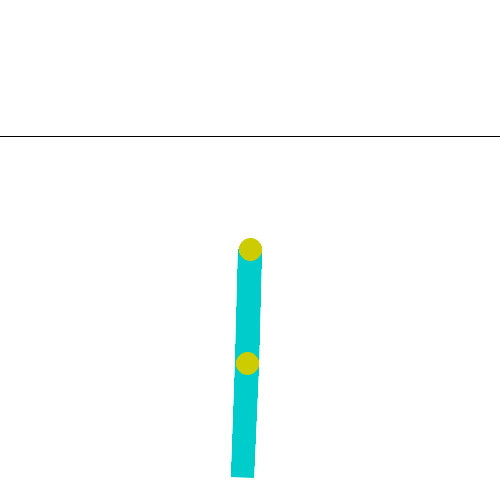

In [37]:
observation = env.reset()
PIL.Image.fromarray(env.render())

In [38]:
state_shape = env.observation_space.shape
num_actions = env.action_space.n

In [39]:
print(f"Robot can take {num_actions} actions and has {state_shape[0]} parameters in its state!")

Robot can take 3 actions and has 6 parameters in its state!


<div class="table-wrapper colwidths-auto docutils container">
<table class="docutils align-default">
<thead>
<tr class="row-odd"><th class="head"><p>Num</p></th>
<th class="head"><p>Action</p></th>
<th class="head"><p>Unit</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>0</p></td>
<td><p>apply -1 torque to the actuated joint</p></td>
<td><p>torque (N m)</p></td>
</tr>
<tr class="row-odd"><td><p>1</p></td>
<td><p>apply 0 torque to the actuated joint</p></td>
<td><p>torque (N m)</p></td>
</tr>
<tr class="row-even"><td><p>2</p></td>
<td><p>apply 1 torque to the actuated joint</p></td>
<td><p>torque (N m)</p></td>
</tr>
</tbody>
</table>
</div>

In [40]:
GAMMA = 0.995
MIN_EPSILON = 0.01
TAU = 0.01
ALPHA=0.001
MAX_BUFFER_SIZE = 100000
NUM_STEPS_FOR_UPDATE = 4
MINIBATCH_SIZE = 64
EPSILON_DECAYRATE = 0.9

In [41]:
q_network = Sequential([
    Input(shape=state_shape),
    Dense(units=64, activation="relu"),
    Dense(units=32, activation="relu"),
    Dense(units=num_actions)
])

target_q_network = Sequential([
    Input(shape=state_shape),
    Dense(units=64, activation="relu"),
    Dense(units=32, activation="relu"),
    Dense(units=num_actions)
])
optimizer = Adam(learning_rate=ALPHA)

In [42]:
experience = namedtuple("Experience", ["state", "action", "reward", "next_state", "done"])

In [43]:
def compute_loss(experiences, q_network, target_q_network):
    states, actions, rewards, next_states, done = experiences
    y_targets = rewards + GAMMA*(tf.reduce_max(target_q_network(next_states), axis=1))*(1-done)
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([range(len(q_values)), tf.cast(actions, dtype=tf.int32),], axis=1))
    return MSE(y_targets, q_values)

In [44]:
def agent_learn(experiences):
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, q_network, target_q_network)
    gradients = tape.gradient(loss, q_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
    for q_net_weights, target_q_net_weights in zip(q_network.weights, target_q_network.weights):
        target_q_net_weights.assign(TAU*q_net_weights + (1-TAU)*target_q_net_weights)

In [45]:
def get_action(q_values, epsilon):
    if random.random() > epsilon:
        return np.argmax(q_values)
    return random.choice(np.arange(num_actions))

In [46]:
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

In [54]:
target_q_network.set_weights(q_network.get_weights())
episodes = 1000
max_time_steps = 500
total_pts_hist = []
epsilon = 1
memory_buffer = deque(maxlen=MAX_BUFFER_SIZE)
num_pav = 75
for i in range(episodes):
    total_pts = 0
    state = env.reset()[0]
    for t in range(max_time_steps):
        q_values = q_network(state.reshape(1, -1))
        action = get_action(q_values, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        memory_buffer.append(experience(state, action, reward, next_state, terminated))
        if len(memory_buffer) > MINIBATCH_SIZE and (t+1)%NUM_STEPS_FOR_UPDATE:
            experiences = get_experiences(memory_buffer)
            agent_learn(experiences)
        total_pts += reward
        if terminated:
            break
        state = next_state.copy()
    print(f"\rEpisode {i+1}: Total Points: {total_pts}", end="")
    if (i+1)%50 == 0:
        print(f"\nEpisode {i+1}: Total Points: {total_pts}", end="")
    epsilon = max(MIN_EPSILON, EPSILON_DECAYRATE*epsilon)
    total_pts_hist.append(total_pts)
    avg_total_pts = np.mean(total_pts_hist[-num_pav:])
    if avg_total_pts >= -100:
        break
q_network.save("./bipedal_walker.keras")
print("\nModel was Saved after successfull training!")

Episode 50: Total Points: -69.00
Episode 78: Total Points: -94.00
Model was Saved after successfull training!


In [55]:
filename = f"./bipedal_walker.mp4"

def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state = env.reset()[0]
        frame = env.render()
        video.append_data(frame)
        while not done:    
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, truncated, _ = env.step(action)
            frame = env.render()
            video.append_data(frame)

def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)
        

create_video(filename, env, q_network)
embed_mp4(filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
